In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define functions
def studentpdf(epsilon, nu):
    # if nu <= 2: 
    #     return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)


def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared


def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu)
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared


# def asymmetric_beta_t_egarch(parameters, returns):
#     mu, lam, phi, kappa, k_tilde, nu = parameters
#     T = len(returns)
#     lambda_t = np.zeros(T)
#     lambda_t[0] = lam  # Starting value for lambda

#     for t in range(T-1):
#         epsilon_t = (returns[t] - mu) / np.exp(lambda_t[t] + 1e-8)
#         u_t = np.sqrt((nu + 3) / (2 * nu)) * ((nu + 1) / (nu - 2 + epsilon_t**2) * epsilon_t**2 - 1)
#         v_t = np.sqrt(((nu - 2) * (nu + 3)) / (nu * (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon_t**2) * epsilon_t)
#         lambda_t[t+1] = lam * (1 - phi) + phi * lambda_t[t] + kappa * u_t + k_tilde * v_t
#     sigmas = np.exp(lambda_t)
#     return sigmas

def asymmetric_beta_t_egarch(parameters, returns):
    mu, lam, phi, kappa, kappa_tilde, nu = parameters
    T = len(returns)
    
    u = np.zeros(T)
    v = np.zeros(T)
    
    epsilon = np.zeros(T)
    lambdas = np.zeros(T)
    sigma = np.zeros(T)
    
    lambda_start = lam
    sigma_start = np.exp(lambda_start)
    
    for t in range(T):
        if t ==1:
            sigma[t] = sigma_start
            lambdas[t] = lambda_start
            epsilon[t] = (returns[t] - mu) * np.exp(-lambdas[t])
            u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
            v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
        else:
            lambdas[t] = lambda_start * (1 - phi) + phi * lambdas[t-1] + kappa * u[t-1] + kappa_tilde * v[t-1]
            sigma[t] = np.exp(lambdas[t])
            epsilon[t] = (returns[t] - mu) * np.exp(-lambdas[t])
            u[t] = np.sqrt((nu + 3) / (2 * nu)) * (((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]**2 - 1)
            v[t] = np.sqrt((nu + 2) * (nu + 3) / (nu + (nu + 1))) * ((nu + 1) / (nu - 2 + epsilon[t]**2)) * epsilon[t]
    return sigma, u, v

def negative_log_likelihood(parameters, returns, model_type):
    """negative log-likelihood function"""
    mu = parameters[0]
    nu = parameters[-1]
    if model_type == 'GARCH':
        omega, alpha, beta = parameters[1:-1]
        sigma_squared = garch(mu, omega, alpha, beta, returns)
    elif model_type == 'Asymmetric GARCH':
        omega, alpha_pos, alpha_neg, beta = parameters[1:-1]
        sigma_squared = asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns)
    elif model_type == 'Asymmetric Beta-t-EGARCH' or 'Symmetric Beta-t-EGARCH':
        lam, phi, kappa, k_tilde = parameters[1:-1]
        sigma_squared, _, _ = asymmetric_beta_t_egarch(parameters, returns)
    else:
        raise ValueError("Invalid model type")
    
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)


def optimize_model(model_type, initial_values, bounds, returns):
    """optimization function for different volatility models."""
    result = optimize.minimize(negative_log_likelihood, initial_values, args=(returns, model_type), bounds=bounds, method='Nelder-Mead')
    return result

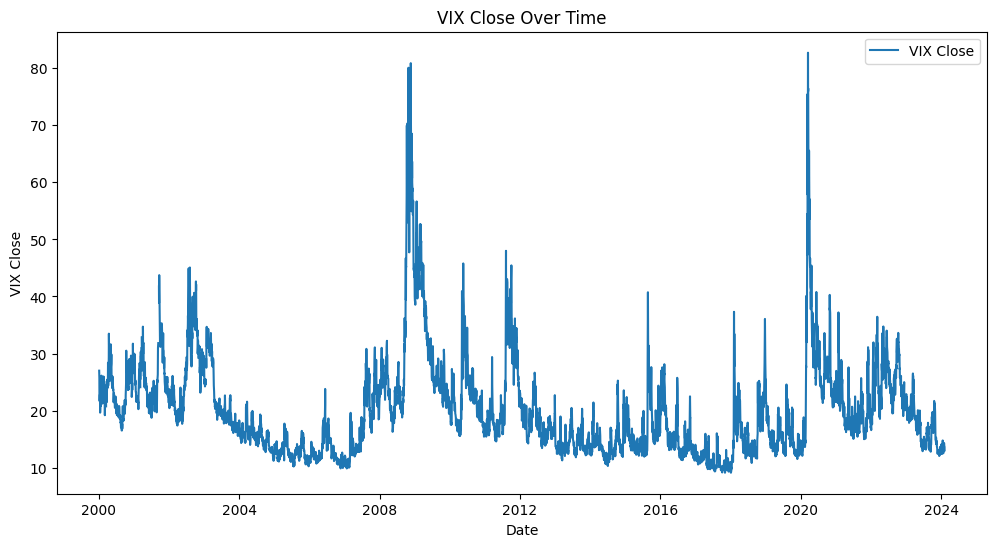

In [3]:
# Read data
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

# Plot VIX
plt.figure(figsize=(12, 6))
plt.plot(data['VIX close'], label='VIX Close')
plt.legend()
plt.title('VIX Close Over Time')
plt.xlabel('Date')
plt.ylabel('VIX Close')
plt.show()


# Symmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:88: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:89: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))


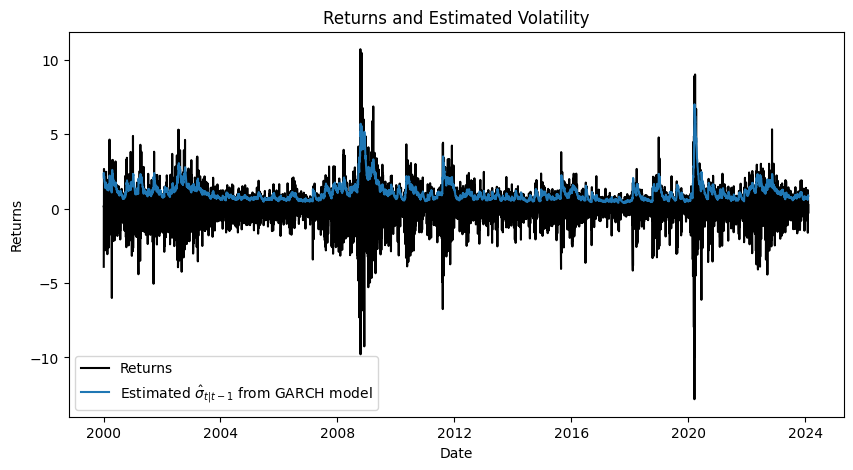

Optimization Successful: Yes
Estimated Parameters:
  mu    : 0.076
  omega : 0.013
  alpha : 0.121
  beta  : 0.876
  nu    : 6.470
Log-Likelihood: -8211.3


In [4]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
log_likelihood = -result.fun
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\hat{\sigma}_{t|t-1}$ from GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu    : {mu_hat:.3f}")
print(f"  omega : {omega_hat:.3f}")
print(f"  alpha : {alpha_hat:.3f}")
print(f"  beta  : {beta_hat:.3f}")
print(f"  nu    : {nu_hat:.3f}")

print(f"Log-Likelihood: {log_likelihood:.1f}")

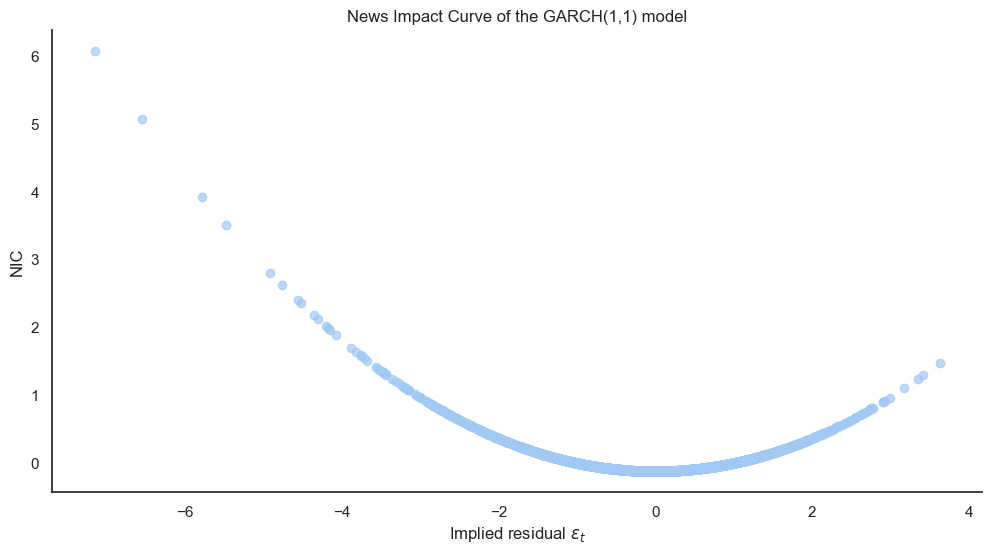

In [5]:
sns.set(palette='pastel', font='serif')
sns.set_style('white')

conditional_var = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat * (epsilon**2 * (epsilon < 0) - 1/2)
plt.figure(figsize=(12, 6))
plt.scatter(epsilon, nic, alpha=0.7)
plt.xlabel('Implied residual $\epsilon_t$')
plt.ylabel('NIC')
plt.title('News Impact Curve of the GARCH(1,1) model')
sns.despine()

plt.show()

# Asymmetric GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:88: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:89: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))


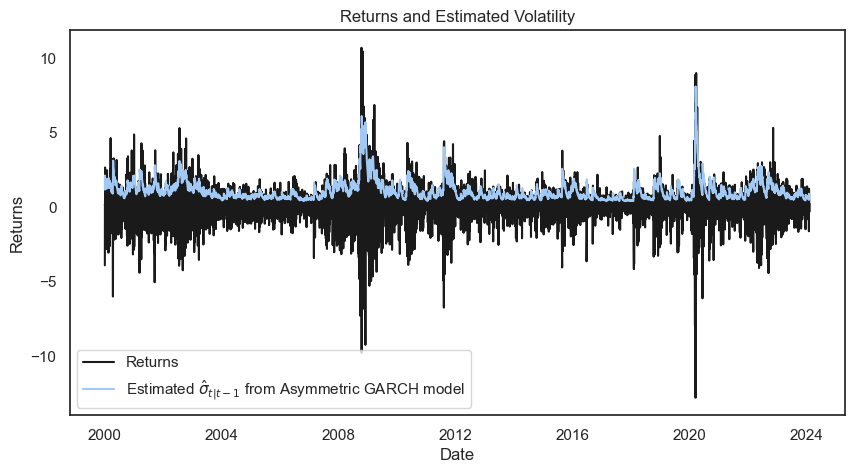

Optimization Successful: Yes
Estimated Parameters:
  mu          : 0.046
  omega       : 0.017
  alpha_pos   : 0.000
  alpha_neg   : 0.208
  beta        : 0.884
  nu          : 6.892
Log-Likelihood: -8111.4


In [6]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize_model('Asymmetric GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
log_likelihood = -result.fun

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)), label='Estimated $\hat{\sigma}_{t|t-1}$ from Asymmetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu          : {mu_hat:.3f}")
print(f"  omega       : {omega_hat:.3f}")
print(f"  alpha_pos   : {alpha_hat_pos:.3f}")
print(f"  alpha_neg   : {alpha_hat_neg:.3f}")
print(f"  beta        : {beta_hat:.3f}")
print(f"  nu          : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

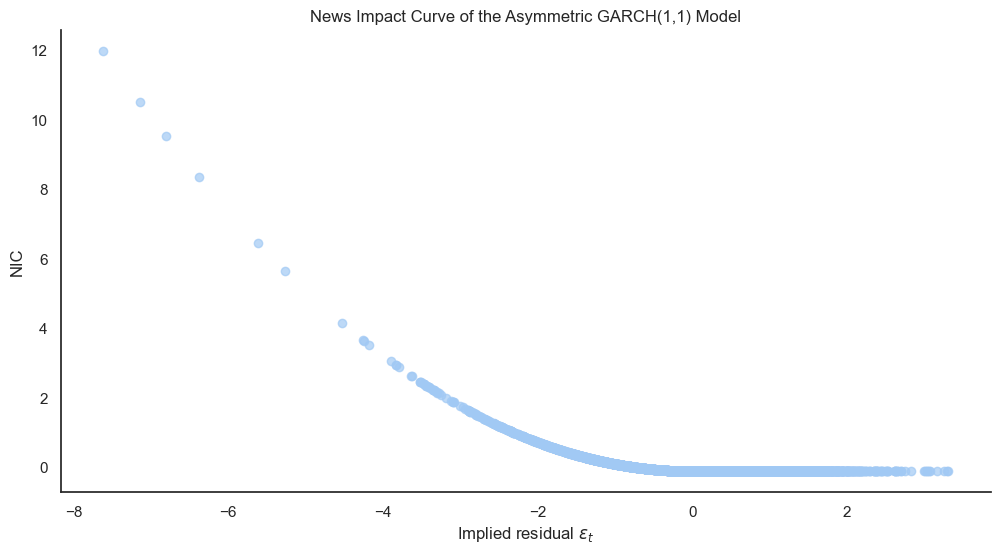

In [7]:
sns.set(palette='pastel', font='serif')
sns.set_style('white')

conditional_var = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = alpha_hat_pos * (epsilon**2 * (epsilon >= 0) - 1/2) + alpha_hat_neg * (epsilon**2 * (epsilon < 0) - 1/2)
plt.figure(figsize=(12, 6))
plt.scatter(epsilon, nic, alpha=0.7)
plt.xlabel('Implied residual $\epsilon_t$')
plt.ylabel('NIC')
plt.title('News Impact Curve of the Asymmetric GARCH(1,1) Model')
sns.despine()

plt.show()

# Symmetric Beta-t-GARCH

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:95: OptimizeWarning: Initial guess is not within the specified bounds
  result = optimize.minimize(negative_log_likelihood, initial_values, args=(returns, model_type), bounds=bounds, method='Nelder-Mead')
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:66: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])


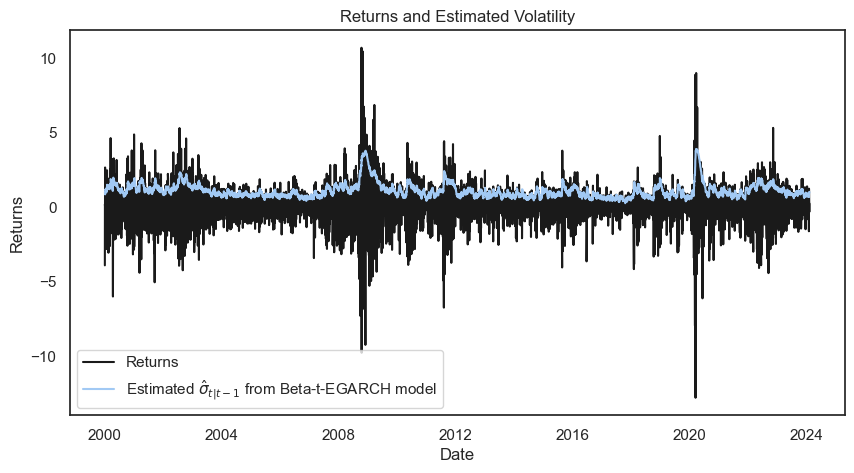

Optimization Successful: Yes
Estimated Parameters:
  mu     : 0.077
  lam    : -0.010
  phi    : 1.045
  kappa  : 0.163
  k_tilde: 0.000
  nu     : 5.500
Log-Likelihood: -8276.1


In [16]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (0, 0), (2, 40)] # Constrain kappa_tilde = 0
result = optimize_model('Symmetric Beta-t-GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(asymmetric_beta_t_egarch(result.x, returns)[0]), label='Estimated $\hat{\sigma}_{t|t-1}$ from Beta-t-EGARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

# Print results
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

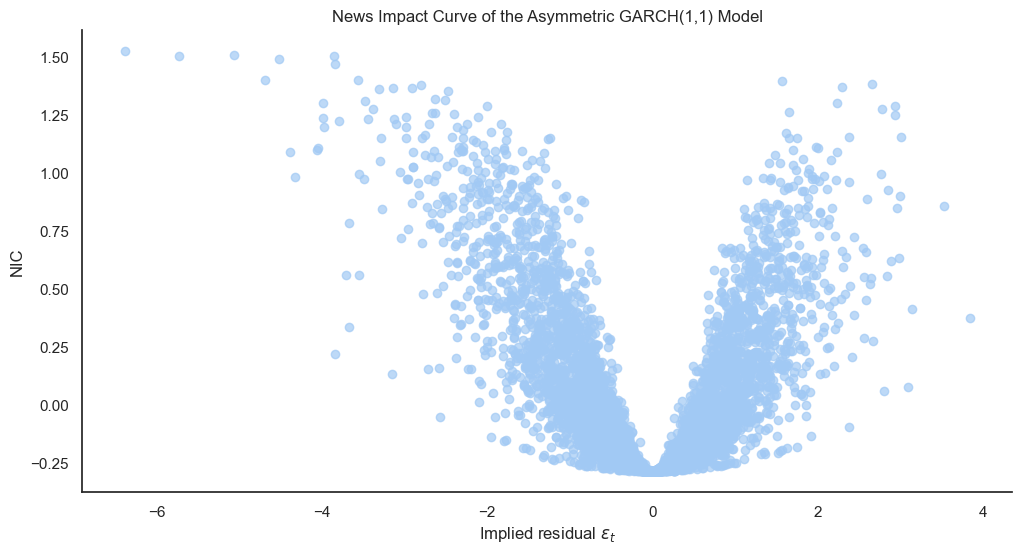

In [18]:
sns.set(palette='pastel', font='serif')
sns.set_style('white')

conditional_var, u, v = asymmetric_beta_t_egarch(result.x, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = 2 * kappa_hat * u + 2 * k_tilde_hat * v
plt.figure(figsize=(12, 6))
plt.scatter(epsilon, nic, alpha=0.7)
plt.xlabel('Implied residual $\epsilon_t$')
plt.ylabel('NIC')
plt.title('News Impact Curve of the Symmetric Beta-t-EGARCH Model')
sns.despine()
plt.show()

# Asymmetric Beta-t-EGARCH,

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_11891/2229520441.py:66: RuntimeWarning: overflow encountered in exp
  sigma[t] = np.exp(lambdas[t])


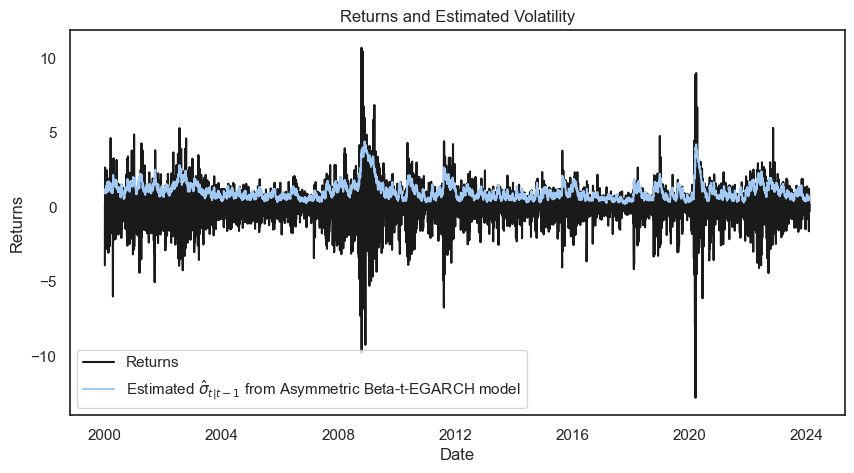

Optimization Successful: No
Estimated Parameters:
  mu     : 0.029
  lam    : 0.374
  phi    : 1.029
  kappa  : 0.100
  k_tilde: -0.073
  nu     : 7.538
Log-Likelihood: -8091.2


In [20]:
# Define optimization problem
initial_values = [np.mean(returns), 0, 0.95, 0.1, 0.1, 6]
bounds = [(None, None), (None, None), (None, None), (None, None), (None, None), (2, None)]
result = optimize_model('Beta-t-GARCH', initial_values, bounds, returns)

# Extract optimized parameters
mu_hat, lam_hat, phi_hat, kappa_hat, k_tilde_hat, nu_hat = result.x
log_likelihood = -result.fun

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(asymmetric_beta_t_egarch(result.x, returns)[0]), label='Estimated $\hat{\sigma}_{t|t-1}$ from Asymmetric Beta-t-EGARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()

# Print results in a structured format
print(f"Optimization Successful: {'Yes' if result.success else 'No'}")
print("Estimated Parameters:")
print(f"  mu     : {mu_hat:.3f}")
print(f"  lam    : {lam_hat:.3f}")
print(f"  phi    : {phi_hat:.3f}")
print(f"  kappa  : {kappa_hat:.3f}")
print(f"  k_tilde: {k_tilde_hat:.3f}")
print(f"  nu     : {nu_hat:.3f}")
print(f"Log-Likelihood: {log_likelihood:.1f}")

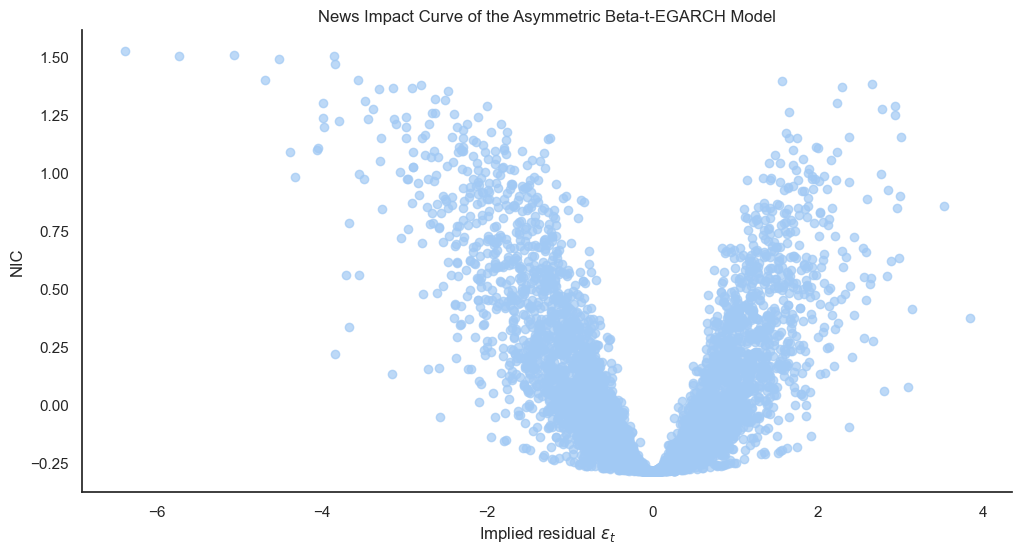

In [19]:
sns.set(palette='pastel', font='serif')
sns.set_style('white')

conditional_var, u, v = asymmetric_beta_t_egarch(result.x, returns)
epsilon = (returns - mu_hat) / np.sqrt(conditional_var)
nic = 2 * kappa_hat * u + 2 * k_tilde_hat * v
plt.figure(figsize=(12, 6))
plt.scatter(epsilon, nic, alpha=0.7)
plt.xlabel('Implied residual $\epsilon_t$')
plt.ylabel('NIC')
plt.title('News Impact Curve of the Asymmetric Beta-t-EGARCH Model')
sns.despine()

plt.show()

In [12]:
asymmetric_beta_t_egarch([0.0360, -0.0291, 0.9741, 0.0608, -0.0905, 8.4964], returns)

(array([0.99924659, 0.97131933, 0.87487911, ..., 0.42256363, 0.33245641,
        0.47682001]),
 array([ 4.69149944, -0.78961359, -0.8170944 , ...,  2.87137611,
         0.34815053, -0.60206573]),
 array([-4.396235  ,  0.62498404,  0.2542989 , ...,  4.81732512,
        -3.44413465,  1.59796291]))

In [13]:
negative_log_likelihood([0.0360, -0.0291, 0.9741, 0.0608, -0.0905, 8.4964], returns, 'asymmetric_beta_t_egarch')

8258.64832284883

In [14]:
negative_log_likelihood(result.x, returns, 'asymmetric Beta-t-EGARCH')

8091.210788200771

In [15]:
result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 8091.210788200771
             x: [ 2.937e-02  3.743e-01  1.029e+00  1.004e-01 -7.302e-02
                  7.538e+00]
           nit: 767
          nfev: 1200
 final_simplex: (array([[ 2.937e-02,  3.743e-01, ..., -7.302e-02,
                         7.538e+00],
                       [ 2.639e-02,  3.048e-01, ..., -7.236e-02,
                         7.722e+00],
                       ...,
                       [ 2.449e-02,  2.672e-01, ..., -7.086e-02,
                         7.629e+00],
                       [ 2.593e-02,  3.158e-01, ..., -7.273e-02,
                         7.423e+00]]), array([ 8.091e+03,  8.091e+03,  8.092e+03,  8.092e+03,
                        8.092e+03,  8.092e+03,  8.092e+03]))